In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

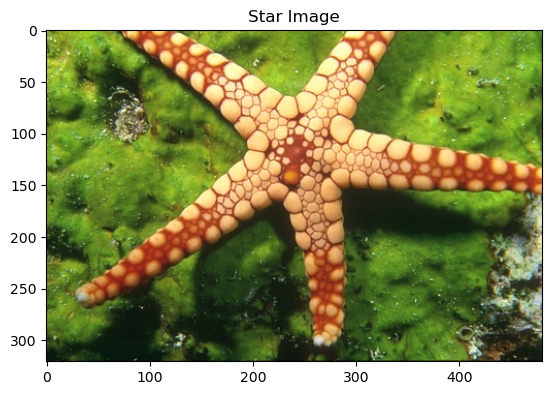

(321, 481, 3)

In [6]:
img_path = 'star.jpg'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title('Star Image')
plt.imshow(img)
plt.show()
img.shape

In [30]:
flattened_img = img.reshape(-1, 3)
flattened_img.shape

(154401, 3)

In [31]:
def downsample_pixels_by_average(img, group_size):
    h, w, c = img.shape
    new_h = h // group_size
    new_w = w // group_size
    new_img = np.zeros((new_h, new_w, c), dtype=np.uint8)
    for i in range(new_h):
        for j in range(new_w):
            new_img[i, j] = np.mean(img[i*group_size:(i+1)*group_size, j*group_size:(j+1)*group_size], axis=(0, 1))
    return new_img

In [32]:
downscaled_img = downsample_pixels_by_average(img, 2)

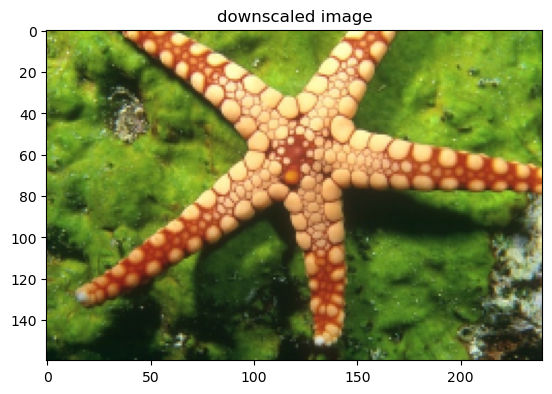

In [151]:
plt.title("downscaled image")
plt.imshow(downscaled_img)
plt.show()

In [152]:
flattened_img = downscaled_img.reshape(-1, 3)
unique_colors = np.unique(flattened_img, axis=0)
unique_colors.shape

(32789, 3)

In [153]:
def kmeans(k, data):
    centers = data[np.random.choice(data.shape[0], k, replace=False)]
    while True:
        labels = np.argmin(np.linalg.norm(data[:, None] - centers, axis=-1), axis=-1)
        new_centers = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return labels, centers

In [154]:
k = 1000
labels, centers = kmeans(k, unique_colors)
centers[labels].shape

(32789, 3)

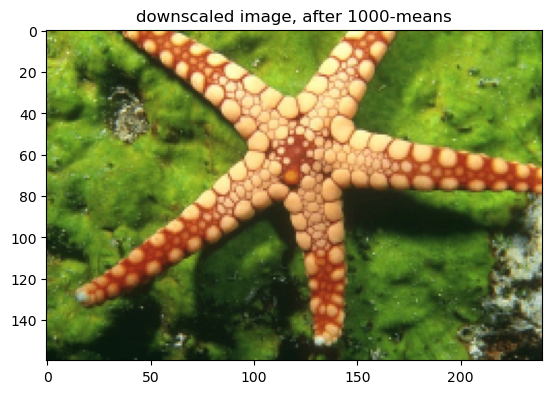

In [155]:
colors_to_centers = {tuple(color): center for color, center in zip(unique_colors, centers[labels])}
clustered_img = np.array([colors_to_centers[tuple(color)] for color in flattened_img])
plt.title("downscaled image, after 1000-means")
plt.imshow(clustered_img.reshape(downscaled_img.shape).astype(np.uint8))
plt.show()

In [156]:
def calculate_distance_matrix(unique_colors):
    return distance_matrix(unique_colors, unique_colors)

In [157]:
dist_matrix = calculate_distance_matrix(centers)
dist_matrix.shape

(1000, 1000)

In [158]:
def average_linkage_agglomerative_clustering_iter(dist_matrix, labels):
    dist_matrix = np.where(dist_matrix == 0, np.inf, dist_matrix)
    i, j = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    labels[labels == j] = i
    labels[labels > j] -= 1
    dist_matrix[i, :] = (dist_matrix[i, :] + dist_matrix[j, :]) / 2
    dist_matrix[:, i] = (dist_matrix[:, i] + dist_matrix[:, j]) / 2
    dist_matrix = np.delete(dist_matrix, j, axis=0)
    dist_matrix = np.delete(dist_matrix, j, axis=1)
    return dist_matrix, labels
    
    

def agglomerative_clustering(n_clusters, dist_matrix):
    labels = np.arange(dist_matrix.shape[0])
    while len(np.unique(labels)) > n_clusters:
        dist_matrix, labels = average_linkage_agglomerative_clustering_iter(dist_matrix, labels)
    return labels
        

In [167]:
labels = agglomerative_clustering(20, dist_matrix)

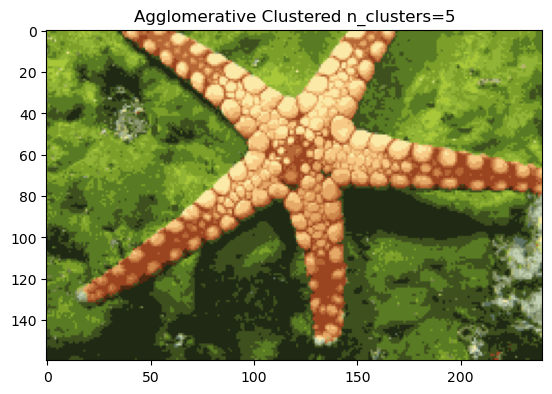

In [168]:
mean_center_in_cluster = np.array([centers[labels == i].mean(axis=0) for i in range(20)])
centers_to_mean_centers = {tuple(center): mean_center_in_cluster[labels[i]] for i, center in enumerate(centers)}
final_img = np.array([centers_to_mean_centers[tuple(colors_to_centers[tuple(color)])] for color in flattened_img])
plt.title("Agglomerative Clustered n_clusters=5")
plt.imshow(final_img.reshape(downscaled_img.shape).astype(np.uint8))
plt.show()

## Pixelwise

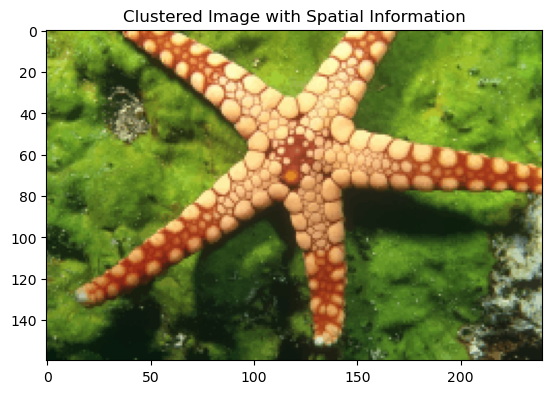

In [209]:
x, y = np.meshgrid(np.arange(downscaled_img.shape[1]), np.arange(downscaled_img.shape[0]))
x = x.flatten()
y = y.flatten()
data = downscaled_img.reshape(-1, 3)
spatial_weight = 0.5
x = (x * spatial_weight).astype(np.float32)
y = (y * spatial_weight).astype(np.float32)
data = np.concatenate([data, x[:, None], y[:, None]], axis=-1)
k = 1000
labels, centers = kmeans(k, data)
clustered_img = centers[labels, :3].reshape(downscaled_img.shape).astype(np.uint8)
plt.title('Clustered Image with Spatial Information')
plt.imshow(clustered_img)
plt.show()

In [210]:
centers.shape

(1000, 5)

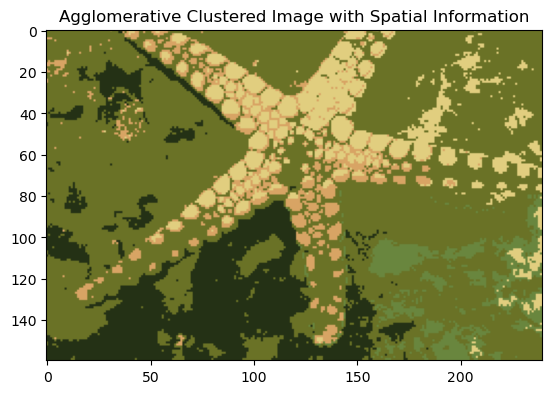

In [215]:
clusters = agglomerative_clustering(5, calculate_distance_matrix(centers))
mean_center_in_cluster = np.array([centers[clusters == i].mean(axis=0) for i in range(5)])
centers_to_mean_centers = {tuple(center): mean_center_in_cluster[clusters[i]] for i, center in enumerate(centers)}
new_centers = np.array([centers_to_mean_centers[tuple(center)] for center in centers])
new_clustered_img = new_centers[labels, :3].reshape(downscaled_img.shape).astype(np.uint8)
plt.title("Agglomerative Clustered Image with Spatial Information")
plt.imshow(new_clustered_img)
plt.show()